<a href="https://colab.research.google.com/github/amardeepambika/My-AIML-Projects/blob/main/Cognizant%20Projects/Cogni_demand_supply_externalhiring_model_v1_ad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

XYZCRM is 1000 headcount strong and serves clients in Salesforce projects. It is fast growing and hires close to 40 new joiners every month. At any point in time there are 150+ demand SOs open.

The client facing teams ope a lot of SOs and plan their projects around the anticipation of fulfillment of those SOs.The company wants to give a sense to its client teams what is the probability of -
- a) fulfilling an SO through external hiring given a certain required by date
- b) fulfilling an SO irrespetive of whether internal or external hiring ( which will need bench details; but a first cut of prediction of fulfimment can be provided without the input of the bench details, assuming the bench inventory does not change much )
- c) they also want to know by changing what features such as 'required on date' or grade or location or on/off etc, will the probability of hiring be 1.

The client teams can do a better job of estimating dates and giving realistic project delivery timelines if they get a sense of the above.

Project scope:
- For now data is for NA_BU (onsite and offshore) Region of the business only. Also some columns such as 'Track' etc can be ignored for now. They can be included when further refining the model in the future.
- For now predict at the country level in terms of US or India. Within country by city you can model later

Project Approach:
 - We will begin by creating a decision tree model that will predict whether a SO will be fulfilled within time or not, given its specific role/location/grade attributes.
 - When we deploy the model on AWS, the user will be able to change the role/loc/grade attributes to check where is the best option for fulfillment to happen.
 - Within this first step we will use SMOTE to add synthetic data given not enough cancelled SOs data set and we will also use GridSearchCV to get the best fit model.
 - As a next step-up we will create multiple models including dDecision Tree, Randomforest, BaggingClassifier, AdaBoosting classifier, GradientBoost.and XGboost classfier to compare different models for bestfit

- As a subsequent step we will create a logistic regression model to arrive at probabilities.



# Data Overview

In [1]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Decision tree classifier for model building
from sklearn.tree import DecisionTreeClassifier

# Library to split data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To build model for prediction
from sklearn import tree
from sklearn import metrics

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)


# To tune different models
from sklearn.model_selection import GridSearchCV

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Read the CSV file from Google Drive
df_load = pd.read_csv("//content/drive/My Drive/Colab Notebooks/ForecastHiringRisks_Cogni/Cleaned_Scoped_DS_Data_for_Modelling_SecAttempt.csv")


Mounted at /content/drive


In [3]:
df_load.head()

,SO Line Status,Action Date,SO Submission Date,Action Date minus Submission date,Subcontractor Allowed by Customer,Interview Required by Customer,Requirement Start Date,Req Start Date minus Submission Date,SO Grade_revised,ROLE_Revised,Demand Role Description,Technical Skills Required,Technical Skills Desired,Functional Skills,Leadership and Prof. Dev. Comp,Additional Skills
0,INTERNAL FULFILMENT,2/27/2024,2/26/2024,2,Y,N,2/26/2024,1,Sr. Dir.,Middle Mgmt,NaN,NaN,NaN,NaN,NaN,NaN
1,INTERNAL FULFILMENT,10/4/2023,10/4/2023,1,Y,Y,10/1/2023,0,SM,Solution Architect,NaN,NaN,NaN,NaN,NaN,NaN
2,INTERNAL FULFILMENT,12/19/2023,12/19/2023,1,Y,Y,1/1/2024,10,SM,Solution Architect,NaN,NaN,NaN,NaN,NaN,NaN
3,CANCELLED,1/5/2024,11/15/2023,38,N,N,2/1/2024,57,SM,BA/SBA,Lead Business Analyst,Business Services,"SFDC Configuration , SFDC Integration , SFDC D...",NaN,NaN,00028562-Commerce Cloud Einstein-1 ~ 00028561-...
4,INTERNAL FULFILMENT,11/17/2023,11/16/2023,2,Y,Y,11/13/2023,0,SM,Solution Architect,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_load.shape

(1193, 16)

In [5]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   SO Line Status                        1193 non-null   object
 1   Action Date                           1193 non-null   object
 2   SO Submission Date                    1193 non-null   object
 3   Action Date minus Submission date     1193 non-null   int64 
 4   Subcontractor Allowed by Customer     1193 non-null   object
 5   Interview Required by Customer        1193 non-null   object
 6   Requirement Start Date                1193 non-null   object
 7   Req Start Date minus Submission Date  1193 non-null   int64 
 8   SO Grade_revised                      1193 non-null   object
 9   ROLE_Revised                          1193 non-null   object
 10  Demand Role Description               814 non-null    object
 11  Technical Skills Required     

# Clean up the data set

In [6]:
# Drop unnecesary columns ; Dont delete 'SO Line Status' because it is the 'y' field ie the output field
df = df_load.copy()
df.drop(columns=['Action Date',"SO Submission Date",'Requirement Start Date','Demand Role Description',
                 'Technical Skills Required','Technical Skills Desired','Functional Skills','Leadership and Prof. Dev. Comp','Additional Skills' ], inplace=True)

In [7]:
#Replace 'EXTERNAL FULFILMENT' with 1,  'INTERNAL FULFILMENT' with 1 and 'CANCELLED' with 0]
df['SO Line Status'].replace(['EXTERNAL FULFILMENT', 'INTERNAL FULFILMENT', 'CANCELLED'], [1, 1, 0], inplace=True)
df['SO Line Status'].value_counts()[1]


835

In [8]:
# prompt: Replace 'Subcontractor Allowed by Customer' with 1 if Y and 0 if N ; similarly for Interview Required by Customer  in df

df['Subcontractor Allowed by Customer'].replace(['Y', 'N'], [1, 0], inplace=True)
df['Interview Required by Customer'].replace(['Y', 'N'], [1, 0], inplace=True)


In [9]:
#show percentage of 1 and 0 in the 'SO Line Status' column
df['SO Line Status'].value_counts(normalize=True)

,proportion
SO Line Status,
1,0.699916
0,0.300084


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   SO Line Status                        1193 non-null   int64 
 1   Action Date minus Submission date     1193 non-null   int64 
 2   Subcontractor Allowed by Customer     1193 non-null   int64 
 3   Interview Required by Customer        1193 non-null   int64 
 4   Req Start Date minus Submission Date  1193 non-null   int64 
 5   SO Grade_revised                      1193 non-null   object
 6   ROLE_Revised                          1193 non-null   object
dtypes: int64(5), object(2)
memory usage: 65.4+ KB


In [11]:
# Rename column SO Line status with 'Fulfilled Y/N'
df.rename(columns={'SO Line Status': 'Fulfilled Y/N'}, inplace=True)

In [12]:
df.head()

,Fulfilled Y/N,Action Date minus Submission date,Subcontractor Allowed by Customer,Interview Required by Customer,Req Start Date minus Submission Date,SO Grade_revised,ROLE_Revised
0,1,2,1,0,1,Sr. Dir.,Middle Mgmt
1,1,1,1,1,0,SM,Solution Architect
2,1,1,1,1,10,SM,Solution Architect
3,0,38,0,0,57,SM,BA/SBA
4,1,2,1,1,0,SM,Solution Architect


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Fulfilled Y/N                         1193 non-null   int64 
 1   Action Date minus Submission date     1193 non-null   int64 
 2   Subcontractor Allowed by Customer     1193 non-null   int64 
 3   Interview Required by Customer        1193 non-null   int64 
 4   Req Start Date minus Submission Date  1193 non-null   int64 
 5   SO Grade_revised                      1193 non-null   object
 6   ROLE_Revised                          1193 non-null   object
dtypes: int64(5), object(2)
memory usage: 65.4+ KB


In [14]:
# prompt: print all theunique values of object datatype columns
for col in df.select_dtypes(include='object').columns:
  print(f"{col}: {df[col].unique()}")
  print('-'*30)

SO Grade_revised: ['Sr. Dir.' 'SM' 'D' 'M' 'AD' 'SA' 'A' 'PA']
------------------------------
ROLE_Revised: ['Middle Mgmt' 'Solution Architect' 'BA/SBA' 'Admin/Sr.Admin/Developer'
 'Tech Architect' 'Sr.Dev/TechLead' 'PM/PgM']
------------------------------


In [15]:
# prompt: convert all object datatypes in df dataframe to category columns
for col in df.select_dtypes(include='object').columns:
  df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   Fulfilled Y/N                         1193 non-null   int64   
 1   Action Date minus Submission date     1193 non-null   int64   
 2   Subcontractor Allowed by Customer     1193 non-null   int64   
 3   Interview Required by Customer        1193 non-null   int64   
 4   Req Start Date minus Submission Date  1193 non-null   int64   
 5   SO Grade_revised                      1193 non-null   category
 6   ROLE_Revised                          1193 non-null   category
dtypes: category(2), int64(5)
memory usage: 49.8 KB


In [16]:
df.isna().sum()

,0
Fulfilled Y/N,0
Action Date minus Submission date,0
Subcontractor Allowed by Customer,0
Interview Required by Customer,0
Req Start Date minus Submission Date,0
SO Grade_revised,0
ROLE_Revised,0


In [17]:
df.nunique()

,0
Fulfilled Y/N,2
Action Date minus Submission date,84
Subcontractor Allowed by Customer,2
Interview Required by Customer,2
Req Start Date minus Submission Date,94
SO Grade_revised,8
ROLE_Revised,7


In [18]:
for col in df.select_dtypes(include='category').columns:
  print(df[col].value_counts())
  print('-'*30)

SO Grade_revised
M           296
A           244
SM          242
SA          218
AD          155
PA           18
D            17
Sr. Dir.      3
Name: count, dtype: int64
------------------------------
ROLE_Revised
Sr.Dev/TechLead             386
Tech Architect              247
Admin/Sr.Admin/Developer    240
PM/PgM                      107
Solution Architect           92
BA/SBA                       67
Middle Mgmt                  54
Name: count, dtype: int64
------------------------------


# Exploratory Data Analysis

In [19]:
#The below code is a function to create labeled barplots. We will use this function also in analysis that is to follow.

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=8)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=6,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    # Get the current figure and change its width to 15 inches and its height to 2 inches
    fig = plt.gcf()
    fig.set_figwidth(3)
    fig.set_figheight(5)

    plt.tight_layout()

    plt.show()  # show the plot

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   Fulfilled Y/N                         1193 non-null   int64   
 1   Action Date minus Submission date     1193 non-null   int64   
 2   Subcontractor Allowed by Customer     1193 non-null   int64   
 3   Interview Required by Customer        1193 non-null   int64   
 4   Req Start Date minus Submission Date  1193 non-null   int64   
 5   SO Grade_revised                      1193 non-null   category
 6   ROLE_Revised                          1193 non-null   category
dtypes: category(2), int64(5)
memory usage: 49.8 KB


# Univariate analysis

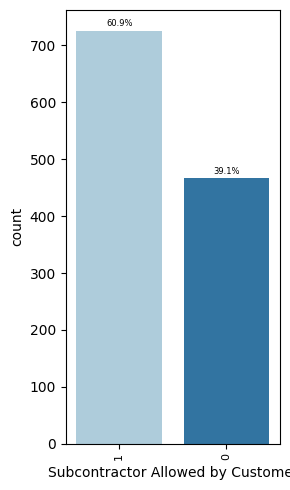

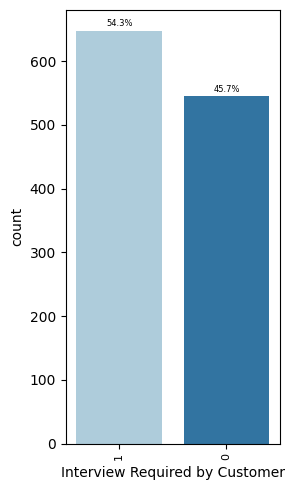

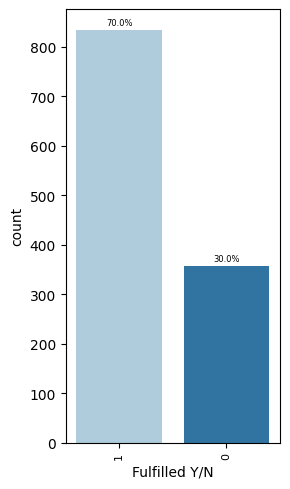

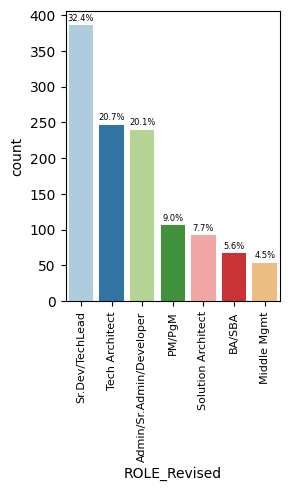

In [21]:
#Create barplots for all categorical variables except for ZIP code
categorical_variables = ['Subcontractor Allowed by Customer','Interview Required by Customer','Fulfilled Y/N','ROLE_Revised']

df_with_cat_cols = df[categorical_variables].copy()
for i in df_with_cat_cols.columns.to_list():
  labeled_barplot(df_with_cat_cols,i,perc=True)

#Bivariate Analysis

In [22]:
### The below code is a function to plot stacked barplot with target variable. We will use this in the bivariate analysis that will follow further down.

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True, normalize='index')#.sort_values(by=sorter, ascending=False)
    print(tab1)
    print("-" * 120)

    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(by=sorter, ascending=False)
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    fig = plt.gcf()
    fig.set_figwidth(1.5)
    fig.set_figheight(3)

    plt.show()

Fulfilled Y/N                             0         1
Subcontractor Allowed by Customer                    
0                                  0.526767  0.473233
1                                  0.154270  0.845730
All                                0.300084  0.699916
------------------------------------------------------------------------------------------------------------------------


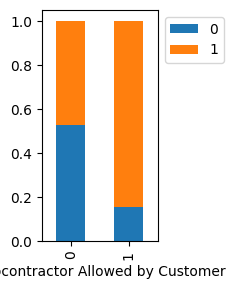

Fulfilled Y/N                          0         1
Interview Required by Customer                    
0                               0.267890  0.732110
1                               0.327160  0.672840
All                             0.300084  0.699916
------------------------------------------------------------------------------------------------------------------------


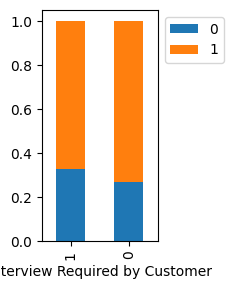

Fulfilled Y/N                    0         1
ROLE_Revised                                
Admin/Sr.Admin/Developer  0.166667  0.833333
BA/SBA                    0.447761  0.552239
Middle Mgmt               0.111111  0.888889
PM/PgM                    0.383178  0.616822
Solution Architect        0.217391  0.782609
Sr.Dev/TechLead           0.360104  0.639896
Tech Architect            0.331984  0.668016
All                       0.300084  0.699916
------------------------------------------------------------------------------------------------------------------------


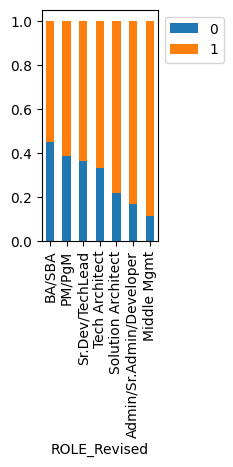

In [23]:
#First, Study the relationship between the target varaible (ie Fuifilled Y/N) and the other categorial variables

df_for_study = df[['Subcontractor Allowed by Customer','Interview Required by Customer','Fulfilled Y/N','ROLE_Revised']].copy()

for i in df_for_study.columns.to_list():
  if(i != 'Fulfilled Y/N'):
    stacked_barplot(df_for_study, i, 'Fulfilled Y/N')

In [24]:
#create a headmap to study/cross-validate relationships-
#quickly select columns of interest to pre-process using one-hot encoding first
df_select_cols_for_heatmap = df.copy()
df_select_cols_for_heatmap = pd.get_dummies(df_select_cols_for_heatmap) # dont drop any column

df_select_cols_for_heatmap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   Fulfilled Y/N                          1193 non-null   int64
 1   Action Date minus Submission date      1193 non-null   int64
 2   Subcontractor Allowed by Customer      1193 non-null   int64
 3   Interview Required by Customer         1193 non-null   int64
 4   Req Start Date minus Submission Date   1193 non-null   int64
 5   SO Grade_revised_A                     1193 non-null   bool 
 6   SO Grade_revised_AD                    1193 non-null   bool 
 7   SO Grade_revised_D                     1193 non-null   bool 
 8   SO Grade_revised_M                     1193 non-null   bool 
 9   SO Grade_revised_PA                    1193 non-null   bool 
 10  SO Grade_revised_SA                    1193 non-null   bool 
 11  SO Grade_revised_SM           

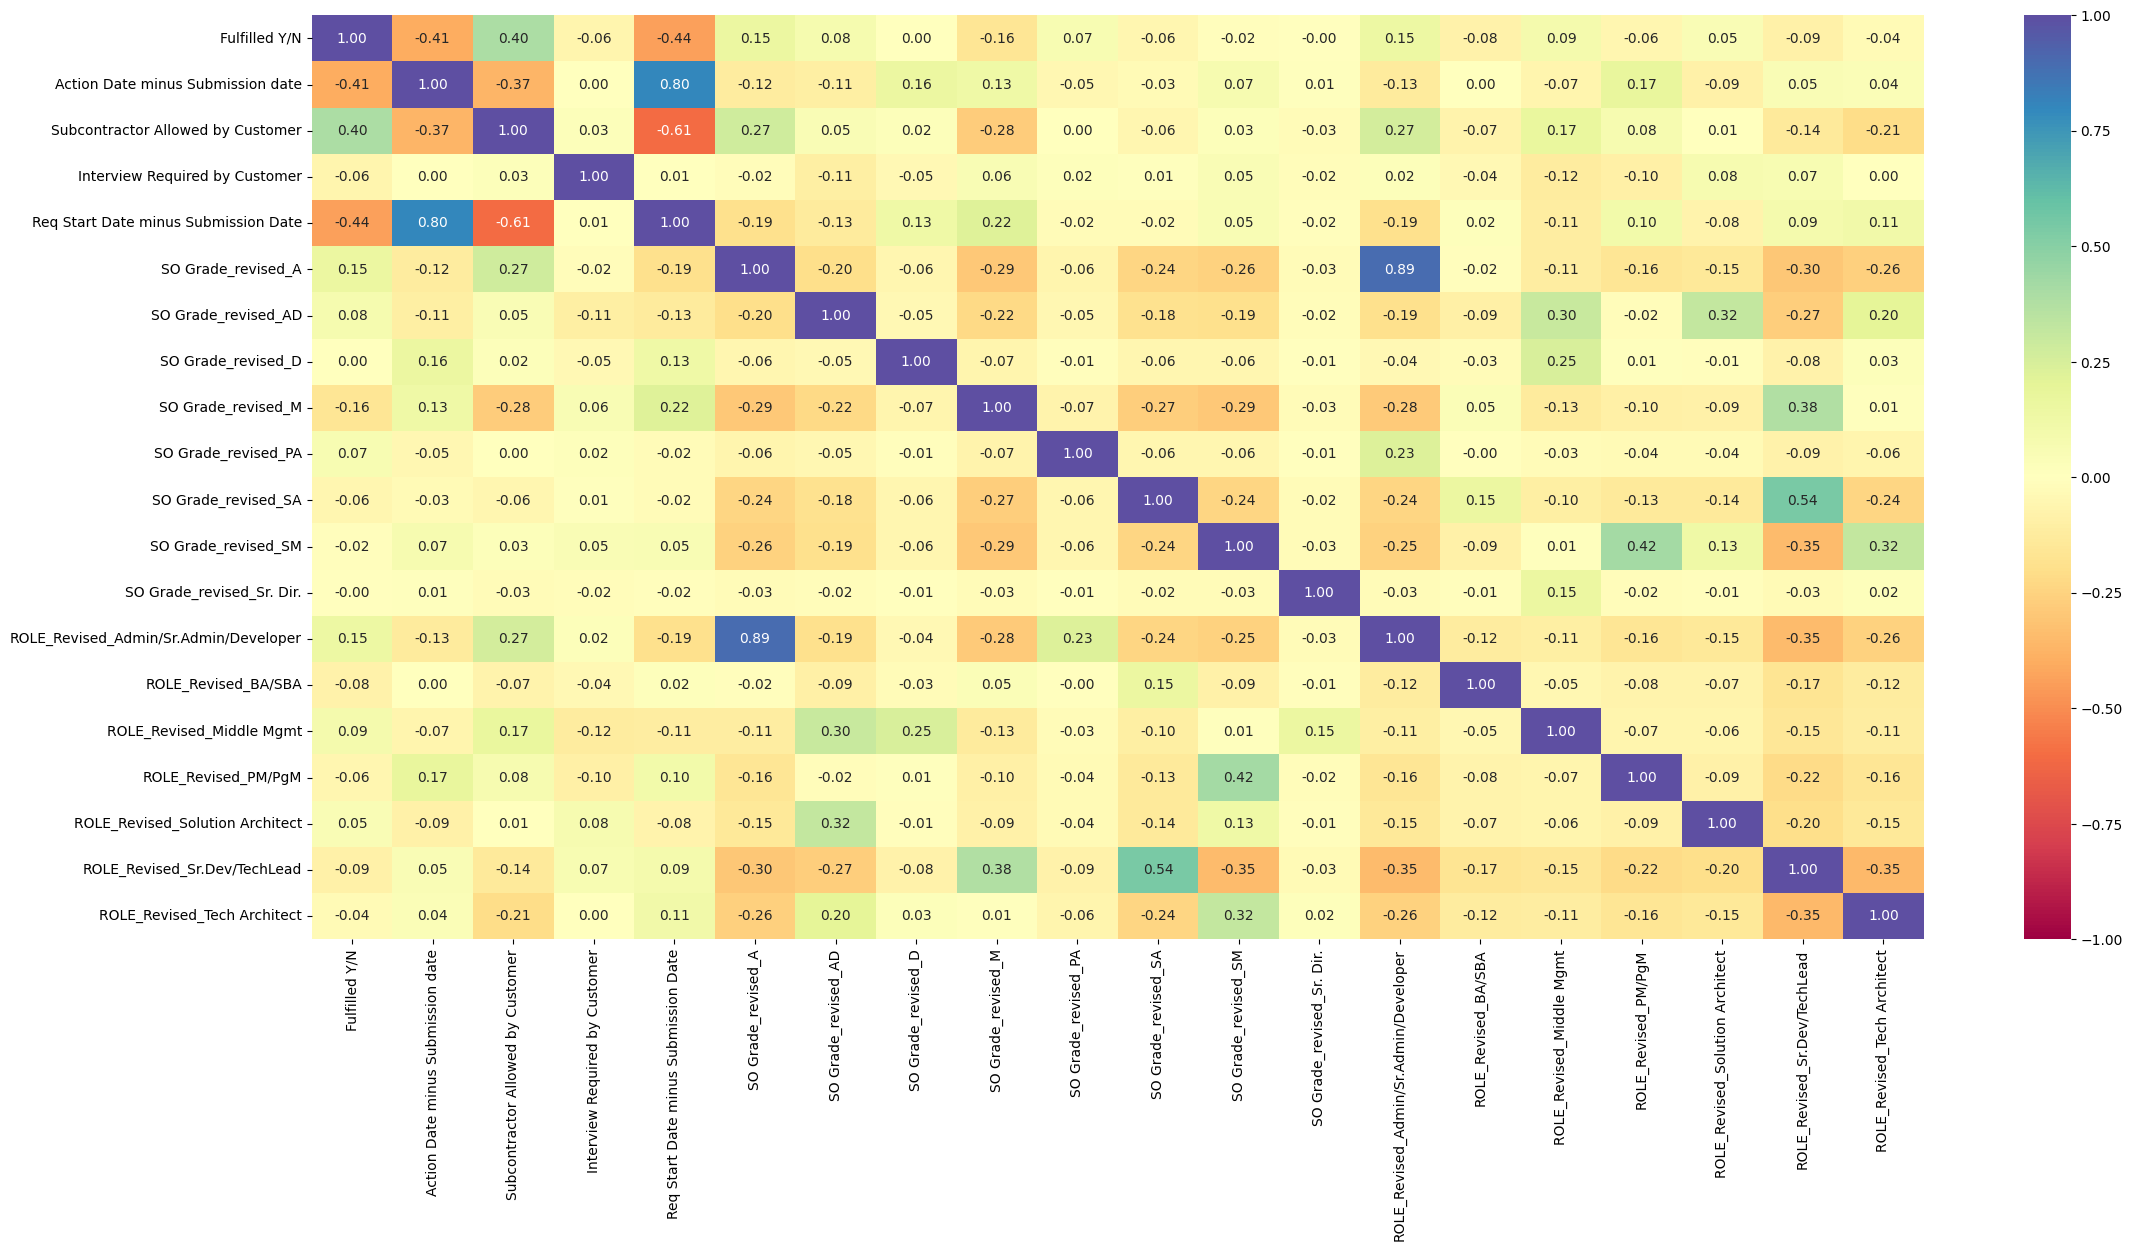

In [25]:
plt.figure(figsize=(26, 12))
sns.heatmap(df_select_cols_for_heatmap.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

#Data Preprocesssing for model building

In [26]:
df.head(5)

,Fulfilled Y/N,Action Date minus Submission date,Subcontractor Allowed by Customer,Interview Required by Customer,Req Start Date minus Submission Date,SO Grade_revised,ROLE_Revised
0,1,2,1,0,1,Sr. Dir.,Middle Mgmt
1,1,1,1,1,0,SM,Solution Architect
2,1,1,1,1,10,SM,Solution Architect
3,0,38,0,0,57,SM,BA/SBA
4,1,2,1,1,0,SM,Solution Architect


In [27]:
# do the get dumies ie one hot encoding with one dummy dropped
# no need to scale the data or treat outliers because decison trees are immune to scaling as well as outliners ( because no eucliedian dist. is involved)

df_select_cols_for_model = pd.get_dummies(df,drop_first=True)

In [28]:
df_select_cols_for_model.head(5)

,Fulfilled Y/N,Action Date minus Submission date,Subcontractor Allowed by Customer,Interview Required by Customer,Req Start Date minus Submission Date,SO Grade_revised_AD,SO Grade_revised_D,SO Grade_revised_M,SO Grade_revised_PA,SO Grade_revised_SA,SO Grade_revised_SM,SO Grade_revised_Sr. Dir.,ROLE_Revised_BA/SBA,ROLE_Revised_Middle Mgmt,ROLE_Revised_PM/PgM,ROLE_Revised_Solution Architect,ROLE_Revised_Sr.Dev/TechLead,ROLE_Revised_Tech Architect
0,1,2,1,0,1,False,False,False,False,False,False,True,False,True,False,False,False,False
1,1,1,1,1,0,False,False,False,False,False,True,False,False,False,False,True,False,False
2,1,1,1,1,10,False,False,False,False,False,True,False,False,False,False,True,False,False
3,0,38,0,0,57,False,False,False,False,False,True,False,True,False,False,False,False,False
4,1,2,1,1,0,False,False,False,False,False,True,False,False,False,False,True,False,False


In [29]:
#seperate x and y variables
X = df_select_cols_for_model.drop('Fulfilled Y/N',axis=1)

y = df_select_cols_for_model["Fulfilled Y/N"]

In [30]:
# Split the data between train,val and test

# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp)

#4. Review the train and test set dataframes

print('X_train Shape:',X_train.shape)
print('y_train Shape:',y_train.shape)

print('X_val Shape:',X_val.shape)
print('y_val Shape:',y_val.shape)

print('X_test Shape:',X_test.shape)
print('y_test Shape:',y_test.shape)

print("\n Percentage of Fulfilled Y/N in the Original dataset:")
print(y.value_counts(normalize=True))
print("\n Percentage of Fulfilled Y/N in training set:")
print(y_train.value_counts(normalize=True))
print("\n Percentage of Fulfilled Y/N  in val set:")
print(y_val.value_counts(normalize=True))
print("\n Percentage of Fulfilled Y/N  in test set:")
print(y_test.value_counts(normalize=True))

X_train Shape: (715, 17)
y_train Shape: (715,)
X_val Shape: (239, 17)
y_val Shape: (239,)
X_test Shape: (239, 17)
y_test Shape: (239,)

 Percentage of Fulfilled Y/N in the Original dataset:
Fulfilled Y/N
1    0.699916
0    0.300084
Name: proportion, dtype: float64

 Percentage of Fulfilled Y/N in training set:
Fulfilled Y/N
1    0.700699
0    0.299301
Name: proportion, dtype: float64

 Percentage of Fulfilled Y/N  in val set:
Fulfilled Y/N
1    0.698745
0    0.301255
Name: proportion, dtype: float64

 Percentage of Fulfilled Y/N  in test set:
Fulfilled Y/N
1    0.698745
0    0.301255
Name: proportion, dtype: float64


In [31]:
# Since the target data has 70% filfilled 'yes' and 30% fulfilled 'no', we will use the SMOTE ( Synthetic minority oversampling techique) to add sythetic data
#Use Synthetic Minority Over Sampling Technique
print("Before Oversampling, counts of Fulfilled 'N' in the train-set target: {}".format(sum(y_train == 0)))
print("Before Oversampling, counts of Fulfilled 'Y' in the train-set target: {}".format(sum(y_train == 1)))

print("Before Oversampling, the shape of train_X: {}".format(X_train.shape))
print("Before Oversampling, the shape of train_y: {}".format(y_train.shape))

sm = SMOTE( sampling_strategy=1, k_neighbors=5, random_state=1)

X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("\nAfter Oversampling, counts of Fulfilled 'N' in the train-set target: {}".format(sum(y_train_over == 0)))
print("After Oversampling, counts of Fulfilled 'Y' in the train-set target: {}".format(sum(y_train_over == 1)))

print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of Fulfilled 'N' in the train-set target: 214
Before Oversampling, counts of Fulfilled 'Y' in the train-set target: 501
Before Oversampling, the shape of train_X: (715, 17)
Before Oversampling, the shape of train_y: (715,)

After Oversampling, counts of Fulfilled 'N' in the train-set target: 501
After Oversampling, counts of Fulfilled 'Y' in the train-set target: 501
After Oversampling, the shape of train_X: (1002, 17)
After Oversampling, the shape of train_y: (1002,) 



#Model Building

###Model Evaluation Criterion

We need to minimize the impact of model making wrong predictions and effecting business outcomes. To that end we have to set up model evaluation criteria in a way that it minimises the impact of wrong preictions. Model can make wrong predictions wrt:
- Making FALSE_POSTIVE predictions ie Predicting that an SO will be fuiflled but in reality the SO is not fuifilled. This will result in lost business and major business impact.
- Making FALSE_NEGATIVE predictions in that the model predicts that an SO will not be fuifilled but in reality the SO gets fulfilled. This is relatively a less impacting scenario.

Therefore we want to evalute the model with the criteria that MINIMISES FALSE_POSITIVES; in other words MAXIMISES the PRECISION metric.

###Define function to get performace scores and confusion metrics values

In [32]:
#Define a function that returns model performance metrics and confusion matrix in a form of two lists.
#We will call this function every time we 'fit' a model, to check for its performance.

def Predict_And_Get_Performace_sores_and_confusion_matrix(model,X_df,y_df):
  #1. First,get the performance metrics scores
  y_prediction = model.predict(X_df) #predict 'y' using the X data set to being with
  acc = accuracy_score(y_df, y_prediction)  # get Accuracy metrics
  recall = recall_score(y_df, y_prediction)  # get Recall metrics
  precision = precision_score(y_df, y_prediction)  # get Precision metricx
  f1 = f1_score(y_df, y_prediction)  # get F1-score

  #2 Second, get the confusion matrix
  cm = confusion_matrix(y_df, y_prediction).flatten(order='C') #  values as [tn, fp, fn, tp];  tn: true negative count, fp: false positive count, fn: false negative count, and tp:true positive count

  return [acc,recall,precision,f1], list(cm) # return the two lists

####Instantiate and train the model

In [33]:
# Initialize a baseline model using the  Decision Tree Classifier
model_baseline = DecisionTreeClassifier(criterion="gini", random_state=2)

# Train it on training data
model_baseline.fit(X_train_over,y_train_over)

p_scores_tr,cm_scores_tr = Predict_And_Get_Performace_sores_and_confusion_matrix(model_baseline,X_train_over,y_train_over)
p_scores_val,cm_scores_val = Predict_And_Get_Performace_sores_and_confusion_matrix(model_baseline,X_val,y_val)

In [34]:
# prompt: initialise a dictionary and append a key value pair: key is "train_scores" with values p_scores_tr and cm_scores_tr

model_performance_dict = {}
model_performance_dict["Score Headings"] = (['acc','recall','precision','f1'],['tn','fp','fn','tp'])
model_performance_dict["BaselineModel-train_scores"] = (p_scores_tr,cm_scores_tr)
model_performance_dict["BaselineModel-val_scores"] = (p_scores_val,cm_scores_val)

In [35]:
print('train_scores',model_performance_dict["BaselineModel-train_scores"][0]) #[acc,recall,precision,f1]
print('val scores',model_performance_dict["BaselineModel-val_scores"][0])

train_scores [0.9930139720558883, 0.9880239520958084, 0.9979838709677419, 0.9929789368104313]
val scores [0.7615062761506276, 0.8023952095808383, 0.8481012658227848, 0.8246153846153846]


In [36]:
print('train cm',model_performance_dict["BaselineModel-train_scores"][1]) #[tn, fp, fn, tp]
print('val cm',model_performance_dict["BaselineModel-val_scores"][1])

train cm [500, 1, 6, 495]
val cm [48, 24, 33, 134]


- Based on the scores above we see that the decision tree has overfit the training dataset

####Feature importance

                                           Imp
Action Date minus Submission date     0.543072
Req Start Date minus Submission Date  0.255090
SO Grade_revised_SM                   0.032942
Subcontractor Allowed by Customer     0.031921
Interview Required by Customer        0.021582
ROLE_Revised_Tech Architect           0.021466
ROLE_Revised_Sr.Dev/TechLead          0.018620
SO Grade_revised_AD                   0.016848
SO Grade_revised_SA                   0.015354
SO Grade_revised_M                    0.015190
SO Grade_revised_PA                   0.007882
ROLE_Revised_PM/PgM                   0.007216
ROLE_Revised_Solution Architect       0.005070
SO Grade_revised_D                    0.005029
ROLE_Revised_BA/SBA                   0.002718
SO Grade_revised_Sr. Dir.             0.000000
ROLE_Revised_Middle Mgmt              0.000000


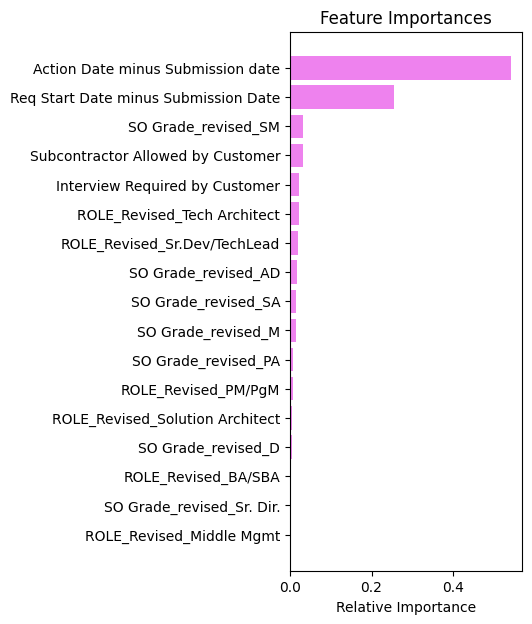

In [37]:
# Lets create a feature importance list for the baseline model. It has overfit with the training set. However this gives us a baseline view.
features_list = list(X_train.columns)

print(pd.DataFrame(model_baseline.feature_importances_, columns=["Imp"], index=X_train.columns).sort_values(by="Imp", ascending=False))

importances = model_baseline.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(3, 7))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [features_list[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

###Model Performance Improvement

####PrePruning

In [38]:
# WE will use the GridSearchCV to find the optimum hyperparameters. Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.

#1. instanciate a new classifier model
model_GridSearchCV_prepruned = DecisionTreeClassifier(random_state=2)

#2. Grid of parameters to choose from:
parameters = {'max_depth': np.arange(1,10),
              'min_samples_leaf': [2, 5, 7, 10, 15],
              'max_leaf_nodes' : [2, 3, 5, 8, 10],
              'min_impurity_decrease': [0.001, 0.01, 0.1],
             }

improvement_scorer = metrics.make_scorer(metrics.precision_score) # set precision metric as the scorer

#2. Run the grid search
grid_obj = GridSearchCV(model_GridSearchCV_prepruned, parameters, scoring=improvement_scorer,cv=5)
grid_obj = grid_obj.fit(X_train_over, y_train_over)

# Set the revised model to the best combination of parameters
model_GridSearchCV_prepruned = grid_obj.best_estimator_

# Fit the revised model to the training data.
model_GridSearchCV_prepruned.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2,
                       min_impurity_decrease=0.001, min_samples_leaf=2,
                       random_state=2)

In [39]:
#1. Get performance metrics and confusion matrix for the prepruned model on its TRAINING set and Val set
p_scores,cm_scores = Predict_And_Get_Performace_sores_and_confusion_matrix(model= model_GridSearchCV_prepruned,X_df=X_train_over,y_df=y_train_over)
model_performance_dict["Prepruned_GS_CV_Model-train_scores"] = (p_scores,cm_scores) ; #[acc,recall,precision,f1] , #[tn, fp, fn, tp]

p_scores,cm_scores = Predict_And_Get_Performace_sores_and_confusion_matrix(model= model_GridSearchCV_prepruned,X_df=X_val,y_df=y_val)
model_performance_dict["Prepruned_GS_CV_Model-val_scores"] = (p_scores,cm_scores) ; #[acc,recall,precision,f1] , #[tn, fp, fn, tp]

In [40]:
#Print all key value pairs in model_performance_dict
for key, value in model_performance_dict.items():
  print(f"{key}: {value[0]}")
print('\n')
for key, value in model_performance_dict.items():
  print(f"{key}: {value[1]}")

Score Headings: ['acc', 'recall', 'precision', 'f1']
BaselineModel-train_scores: [0.9930139720558883, 0.9880239520958084, 0.9979838709677419, 0.9929789368104313]
BaselineModel-val_scores: [0.7615062761506276, 0.8023952095808383, 0.8481012658227848, 0.8246153846153846]
Prepruned_GS_CV_Model-train_scores: [0.7994011976047904, 0.6846307385229541, 0.8886010362694301, 0.7733934611048477]
Prepruned_GS_CV_Model-val_scores: [0.7447698744769874, 0.6646706586826348, 0.9568965517241379, 0.784452296819788]


Score Headings: ['tn', 'fp', 'fn', 'tp']
BaselineModel-train_scores: [500, 1, 6, 495]
BaselineModel-val_scores: [48, 24, 33, 134]
Prepruned_GS_CV_Model-train_scores: [458, 43, 158, 343]
Prepruned_GS_CV_Model-val_scores: [67, 5, 56, 111]


We see that performance of validation set is better than the train set in the Prepruned-GSCV_model

We will finalize the use of this model

### Final model selection for testing with test set and deployment

In [41]:
# test the Prepruned_GS_CV_Model with the test set
p_scores,cm_scores = Predict_And_Get_Performace_sores_and_confusion_matrix(model= model_GridSearchCV_prepruned,X_df=X_test,y_df=y_test)
model_performance_dict["Prepruned_GS_CV_Model-test_scores"] = (p_scores,cm_scores) ; #[acc,recall,precision,f1] , #[tn, fp, fn, tp]


In [42]:
#Print all key value pairs in model_performance_dict
for key, value in model_performance_dict.items():
  print(f"{key}: {value[0]}")
print('\n')
for key, value in model_performance_dict.items():
  print(f"{key}: {value[1]}")

Score Headings: ['acc', 'recall', 'precision', 'f1']
BaselineModel-train_scores: [0.9930139720558883, 0.9880239520958084, 0.9979838709677419, 0.9929789368104313]
BaselineModel-val_scores: [0.7615062761506276, 0.8023952095808383, 0.8481012658227848, 0.8246153846153846]
Prepruned_GS_CV_Model-train_scores: [0.7994011976047904, 0.6846307385229541, 0.8886010362694301, 0.7733934611048477]
Prepruned_GS_CV_Model-val_scores: [0.7447698744769874, 0.6646706586826348, 0.9568965517241379, 0.784452296819788]
Prepruned_GS_CV_Model-test_scores: [0.7447698744769874, 0.6766467065868264, 0.9416666666666667, 0.7874564459930313]


Score Headings: ['tn', 'fp', 'fn', 'tp']
BaselineModel-train_scores: [500, 1, 6, 495]
BaselineModel-val_scores: [48, 24, 33, 134]
Prepruned_GS_CV_Model-train_scores: [458, 43, 158, 343]
Prepruned_GS_CV_Model-val_scores: [67, 5, 56, 111]
Prepruned_GS_CV_Model-test_scores: [65, 7, 54, 113]


We have now created a trained model ("Model Name": model_GridSearchCV_prepruned")with 94% precision score

The next step is to deploy this model for inference.